# STAT 542 - Project 2 - Skin Cancer Diagnostics

Objectives:
* Classify images as malignant or benign using 3 distinct classification algorithms.
* Use non-pixel features and repeat classification to check for improvements in the accuracies and increase in interpretability of the models.

## Importing libraries:

In [36]:
from tqdm import tqdm

#Remove warnings:
import warnings
warnings.filterwarnings('ignore')

#Image reading and processing:
import cv2
import os
from sklearn.decomposition import FastICA, PCA

#Data preprocessing:
from sklearn.model_selection import train_test_split

#Classificaton:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

#Accuracy metrics:
from sklearn.metrics import accuracy_score

%pylab inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.image as mpimg
import seaborn
import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


## Loading data:
The data is present in two different folders - one for benign and one for malignant images. The code below creates functions to load the images into two separate lists and also outputs a few images along with the number of nulls found in each list.

In [77]:
#Base folder:
repo = 'C:/Users/Pulkit Dixit/Desktop/STAT 542/Group Project/Data/542/'

#Function to load images:
def load_images(folder, grayscale = False):
    images = []
    cnt = 0
    for (idx, filename) in enumerate(os.listdir(folder)):
        if grayscale == True:
            img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        else:
            img = cv2.imread(os.path.join(folder, filename))
            b,g,r = cv2.split(img)
            img = cv2.merge([r,g,b])
        
        #Adding image to list:
        if img is not None:
            images.append(img)
            
        #Count number of nulls:
        else:
            cnt = cnt + 1
        
        #Plot images:
        if idx%30 == 0:
            imgplot = plt.imshow(img)
            plt.show()
            
    print(str(len(images))+' images loaded. There were '+str(cnt)+' nulls found in the dataset.')
    return(images)

In [90]:
#Set flag for grayscale images:
grayscaleflag = True

Loading benign images and plotting a few sample images:


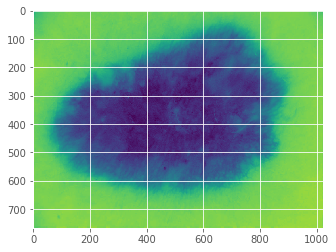

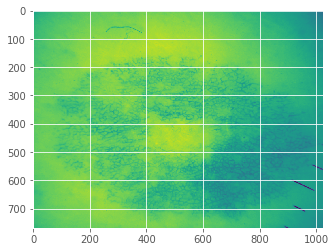

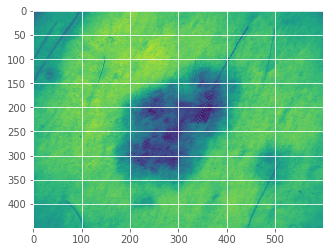

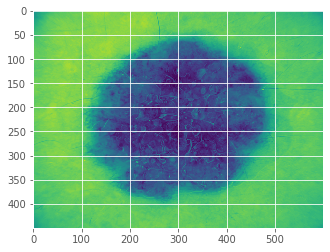

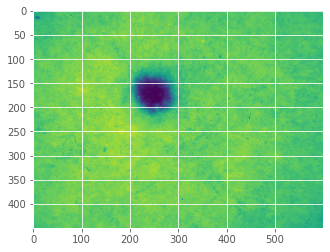

150 images loaded. There were 0 nulls found in the dataset.


In [91]:
#Benign images:
print('Loading benign images and plotting a few sample images:')
benign_images = load_images(repo+'benign/', grayscale = grayscaleflag)

Loading malignant images and plotting a few sample images:


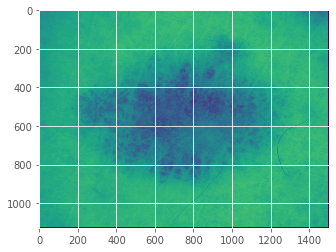

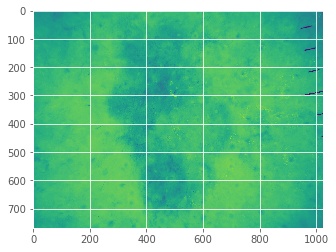

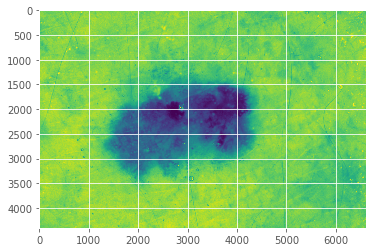

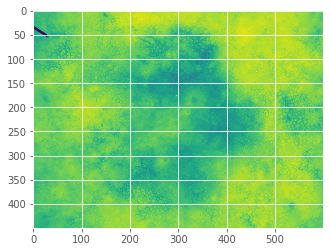

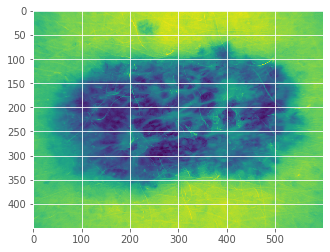

150 images loaded. There were 0 nulls found in the dataset.


In [92]:
#Malignant images:
print('Loading malignant images and plotting a few sample images:')
malignant_images = load_images(repo+'malignant/', grayscale = grayscaleflag)

Both folders have 150 images and no nulls. However, they seem to have different dimensions. They will need to be resized to a common dimension so that they can be flattened and inputted into the classification algorithms.

## Data Processing and Feature Engineering:
The following processing tasks would need to be performed on the images:
* Resizing - the images are of different dimensions and need to be resized to a common set of dimensions.
* Flattening - the images have 3 channels each, and need to be flattened into 1D vectors so that they can be used for feature reduction and classification.
* Normalizing - each pixel of every image is a value in the range 0-255. They need to normalized so that none of paarameters of the classification algorithms explode due to very high values.

In [95]:
def resize_images(images, dim):
    return list(map(lambda x: cv2.resize(x, dsize = dim, interpolation = cv2.INTER_CUBIC), images))

def flatten_images(images, h, w, channels, grayscale = False):
    if grayscale == True:
        return list(map(lambda x: x.reshape(h*w), images)) #for grayscale
    else:
        return list(map(lambda x: x.reshape(h*w*channels), images)) #for non-grayscale

def normalize_images(images):
    return list(map(lambda x: cv2.normalize(x, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).flatten('F'), images))

In [96]:
'''
Function for pre-processing both benign and malignant images. The following operations are performed:
1. Re-size to a common image size.
2. Flatten images into a vector.
3. Normalize images.
'''

def preprocess_images(images, h, w, grayscale = False):
    gsflag = grayscale
    channels = 3
    resized = resize_images(images, (h, w))
    flattened = flatten_images(resized, h, w, channels, grayscale = gsflag)
    normalized = normalize_images(flattened)
    return(np.array(normalized))

benign_processed = preprocess_images(benign_images, h = 256, w = 256, grayscale = grayscaleflag)
malignant_processed = preprocess_images(malignant_images, h = 256, w = 256, grayscale = grayscaleflag)

Labels need to be created for both classes of images (Benign = 0, Malignant = 1)

In [97]:
benign_label = np.zeros(benign_processed.shape[0])
malignant_label = np.ones(benign_processed.shape[0])

The two classes of images and labels are present in separate variables and need to be concatenated so that they can be randomly split into train and test sets.

In [98]:
#labels
y = np.concatenate((benign_label, malignant_label), axis=0)

#data
X = np.concatenate((benign_processed, malignant_processed), axis=0)

Splitting into train and test sets:

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 1)

print('Shape of train set: ', X_train.shape)
print('Shape of test set: ', X_test.shape)

Shape of train set:  (210, 65536)
Shape of test set:  (90, 65536)


It can be noticed that the number of variables is a lot more than the number of data observations. Thus, feature reduction needs to be performed on the images. The code below performs Independent Component Analysis (ICA) on the data:

In [100]:
#ICA
ica = FastICA(n_components = 10, whiten = True)
X_train_reduced = ica.fit_transform(X_train)
X_test_reduced = ica.transform(X_test)

print('Shape of feature-reduced train set: ', X_train_reduced.shape)
print('Shape of feature-reduced test set: ', X_test_reduced.shape)

Shape of feature-reduced train set:  (210, 10)
Shape of feature-reduced test set:  (90, 10)


In [101]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train_reduced, y_train).predict(X_test_reduced)
print(accuracy_score(y_pred, y_test))

0.5222222222222223


In [102]:
lr = LogisticRegression(random_state=0)
y_pred = lr.fit(X_train_reduced, y_train).predict(X_test_reduced)
print(accuracy_score(y_pred, y_test))

0.5222222222222223


In [103]:
#PCA
pca = PCA(n_components = 2)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

print('Shape of feature-reduced train set: ', X_train_reduced.shape)
print('Shape of feature-reduced test set: ', X_test_reduced.shape)

Shape of feature-reduced train set:  (210, 2)
Shape of feature-reduced test set:  (90, 2)


In [104]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train_reduced, y_train).predict(X_test_reduced)
print(accuracy_score(y_pred, y_test))

0.5333333333333333


In [105]:
lr = LogisticRegression(random_state=0)
y_pred = lr.fit(X_train_reduced, y_train).predict(X_test_reduced)
print(accuracy_score(y_pred, y_test))

0.5111111111111111


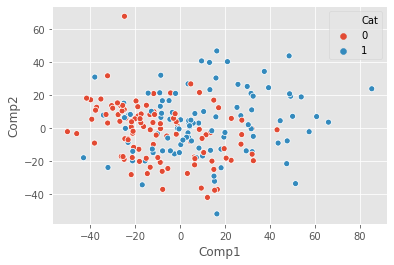

In [51]:
cat = [0,1]
df = pd.DataFrame({
    'Comp1': X_train_reduced[:,0],
    'Comp2': X_train_reduced[:,1],
    'Cat': y_train
})

fg = seaborn.scatterplot(x = df['Comp1'], y = df['Comp2'], hue=df['Cat'], hue_order=cat)
#plt.scatter(x = X_train_reduced[:,0], y = X_train_reduced[:,1])

In [52]:
print(benign_processed[0].shape)

(65536,)


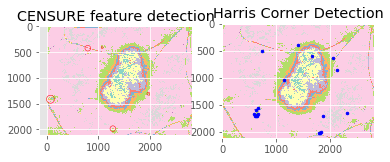

In [94]:
from skimage.feature import corner_harris, corner_subpix, corner_peaks, CENSURE
img = malignant_images[1]
detector = CENSURE()
detector.detect(img)

coords = corner_peaks(corner_harris(img), min_distance=5)
coords_subpix = corner_subpix(img, coords, window_size=13)

plt.subplot(121)
plt.title('CENSURE feature detection')
plt.imshow(img, cmap='Set3')
plt.scatter(detector.keypoints[:, 1], detector.keypoints[:, 0],
              2 ** detector.scales, facecolors='none', edgecolors='r')

plt.subplot(122)
plt.title('Harris Corner Detection')
plt.imshow(img, cmap='Set3')  # show me the leaf
plt.plot(coords[:, 1], coords[:, 0], '.b', markersize=5)
plt.show()

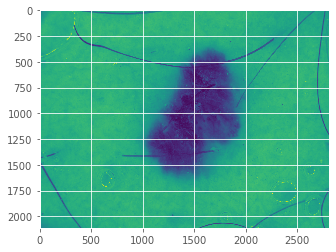

In [93]:
imgplot = plt.imshow(malignant_images[1])
plt.show()